# Module 7 - Additional Concepts


### Notes:

- Simulated annealing for learning rate
    - Purpose
    - Theory
    - Implementation
- Gradient clipping
    - Probably need tensorboard for this.
    - Purpose
    - Theory
    - Implementation
- Dropout
    - Purpose
    - Theory
    - Implementation

We've convered the basics, now let's fine tune our approach!

We'll discuss:

- Varying the learning rate using *Simulated Annealing*
- Constraining the value of the gradients through *Gradient Clipping*
- Reducing overfitting through *Dropout*

First, the usual setup including loading of the skeleton classifier.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf

import sys
sys.path.insert(0,'../PythonModules')

import LectureClassifier as lc

dataset = '../../ARC_NN_Course_Data/AiBi.ubyte.pkl.xz'

## Exponential Decay for the Learning Rate

### The Problem

- The challenge in setting a learning rate is to balance:
  1. Rapidly moving toward optimality
  1. Not overshooting the maxima

### The Solution

- Reduce the learning rate over time
- Sample method: Exponential Decay

### Exponential Decay

\begin{align}
dlr &= lr * dr^{\frac{gs}{ds}}\\
\\
\text{Where: } dlr &= \text{Delayed learning rate}\\
lr &= \text{User specified learning rate}\\
dr &= \text{User specified decay rate}\\
gs &= \text{Global step}\\
ds &= \text{User specified decay steps}
\end{align}

### Which looks like:

<IPython.core.display.Javascript object>


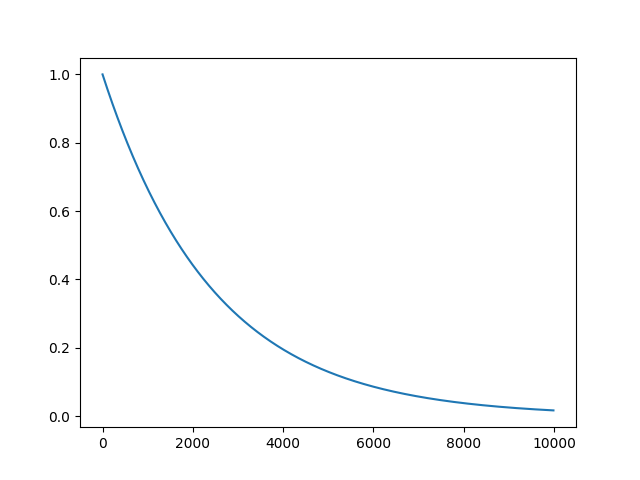

In [2]:
lr = 1.0
dr = 0.96
ds = 100
gs = np.arange(0, 10000, 10)®
dlr = lambda gs : lr * dr ** (gs/ ds)
plt.plot(gs, dlr(gs));

### Implementation

1. Subclass the lecture classifier
1. Override the `optimizer_fn`
1. Add a variable to hold the global step
1. Add an operator to adjust the learning rate using exponential decay
1. Tell the optimizer to update the global step

In [4]:
class DecayLearningRate(lc.Classifier):
    
    def optimizer_fn(self, loss, learning_rate):
        
        with tf.variable_scope("lr", 
                               reuse=tf.AUTO_REUSE):
            global_step = tf.get_variable("global_step", 
                                          initializer=0,
                                          dtype=tf.int32,
                                          trainable=False)

        lr = tf.train.exponential_decay(learning_rate,
                                        global_step,
                                        10,
                                        0.96)
        
        return tf.train.GradientDescentOptimizer(lr).minimize(loss,
                                                              global_step=global_step)

### Let's try it

- Create an instance of the `DecayLearningRate` class

In [5]:
dlr=DecayLearningRate()

Created session


- Load the data

In [6]:
dlr.load_data(dataset)

- Build the model

In [7]:
dlr.build_model()

- Train the model

In [8]:
%time dlr.train_it()

Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
CPU times: user 11min 44s, sys: 1min 21s, total: 13min 5s
Wall time: 2min 1s


- Print out the accuracy

In [9]:
dlr.accuracy

0.76724136

## Gradient Clipping

### The Problem

- Gradients, at times, can become so large (in magnitude) they destablize the process

### The Solution

- Restrict the magnitude of the gradients
- To do this we need to change how we're using the optimization class:
  1. Separate the computation of the gradients from their application
  2. Before applying the gradients clip their values based on some function
     - We'll use clip_by_global_norm 
     
         *It's left as an exercise for the user to determine what this is*

### The Code

In [10]:
class GradientClipping(lc.Classifier):
    
    def optimizer_fn(self, loss, learning_rate):

        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        
        grad_list = optimizer.compute_gradients(loss)
        print("grad_list", type(grad_list), len(grad_list))
        
        gradients, variables = zip(*grad_list)
        print("gradients", type(gradients), len(gradients))
        print("variables", type(variables), len(variables))
        
        gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
        print("clipped gradients", type(gradients), len(gradients))
        
        return optimizer.apply_gradients(zip(gradients, variables))

### Let's try it

- Create an instance of the `GradientClipping` class

In [11]:
gc=GradientClipping()

Created session


- Load the data

In [12]:
gc.load_data(dataset)

- Build the model

In [13]:
gc.build_model()

grad_list <class 'list'> 16
gradients <class 'tuple'> 16
variables <class 'tuple'> 16
clipped gradients <class 'list'> 16


- Train the model

In [14]:
%time gc.train_it()

Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
CPU times: user 13min 6s, sys: 1min 20s, total: 14min 27s
Wall time: 2min 11s


- Print out the accuracy

In [15]:
gc.accuracy

0.7801724

## Dropout
### The Problem
- In a full-connected layer neurons develop co-dependency amongst each other during training 
- This tends to reduce the individual power of each neuron

*The result is overfitting*

### The solution

- Reduce co-dependency by randomly *ignoring* neurons

<center>
<img src="../Ancillary/Dropout.png" alt="Perceptron" style="height: 300px"/>
</center>


### Mechanics

- Add a parameter to the `build_model` method of our classifier: `dropout_keep_prob`

    This will be the probability that a given neuron will be retained


- Add Tensorflow operations to the method to invoke dropout on all but the output layer

In [16]:
class Dropout(lc.Classifier):
    
    def build_model(self,
                    layers=None,
                    dropout_keep_prob=None):

        if layers is None:
            layers = self.default_layers(self.width, self.n_classes)

        self.x = tf.placeholder(tf.float32, [None, self.width])
        self.y = tf.placeholder(tf.float32, [None, self.n_classes])

        prev_width = self.width
        curr_y = self.x

        for i, (layer_width, activation_fn, init_factor) in enumerate(layers):
            with tf.name_scope("layer_{}".format(i)):

                W = tf.Variable(tf.random_uniform([prev_width, layer_width],
                                                  -init_factor, init_factor),
                                name='W_{}'.format(i))
                b = tf.Variable(tf.zeros(layer_width),
                                name='b_{}'.format(i))

                curr_y = tf.nn.xw_plus_b(curr_y, W, b,
                                         name="mn_b_{}".format(i))

                if activation_fn:
                    curr_y = activation_fn(curr_y)
                    
                    if dropout_keep_prob is not None:
                        curr_y = tf.nn.dropout(curr_y, dropout_keep_prob)

            prev_width = layer_width

        # Call the loss function to build the graph for the loss function
        scalar_loss = self.loss_fn(self.y, curr_y)

        # Call the optimizer function to build the optimization graph
        self.train_step = self.optimizer_fn(scalar_loss, 0.1)
        correct_prediction = tf.equal(tf.argmax(curr_y, 1), tf.argmax(self.y, 1))
        self._accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
do=Dropout()
do.load_data(dataset)
do.build_model(dropout_keep_prob=0.5)
%time do.train_it()
print(do.accuracy)
del do

### Let's try it

- Create an instance of the `Dropout` class

In [17]:
do=Dropout()

Created session


- Load the data

In [18]:
do.load_data(dataset)

- Build the model

In [19]:
do.build_model()

- Train the model

In [20]:
%time do.train_it()

Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
CPU times: user 11min 55s, sys: 1min 21s, total: 13min 17s
Wall time: 2min 2s


In [21]:
do.accuracy

0.75431037

# And that's it!